In [1]:
import sys
from pathlib import Path


# Add the 'src' directory to the Python path
src_path = Path('../src').resolve()
sys.path.append(str(src_path))

from aspire.volume import Volume
import mrcfile
import numpy as np 
import numpy.linalg as LA 
from viewing_direction import *
from utils import *
from aspire.basis.basis_utils import lgwt
from volume import *
from moments import * 
import matplotlib.pyplot as plt


In [2]:
# plot vMF density 

c = 10
centers = np.random.normal(0,1,size=(c,3))
centers /= LA.norm(centers, axis=1, keepdims=True)
w_vmf = np.random.uniform(0,1,c)
w_vmf = w_vmf/np.sum(w_vmf)


ngrid = 50 
_ths = np.pi*np.arange(ngrid)/ngrid
_phs = 2*np.pi*np.arange(ngrid)/ngrid

ths, phs = np.meshgrid(_ths,_phs,indexing='ij')
ths, phs = ths.flatten(), phs.flatten()

grid = Grid_3d(type='spherical', ths=ths, phs=phs)


kappa = 5
f_vmf = vMF_density(centers,w_vmf,kappa,grid)
f_vmf = f_vmf*np.sin(ths)
f_vmf = f_vmf.reshape((ngrid,ngrid))

In [3]:
# rejection sampling from vMF 
N = 10000
samples = sample_vmf(N,centers,w_vmf,kappa,C=.5)

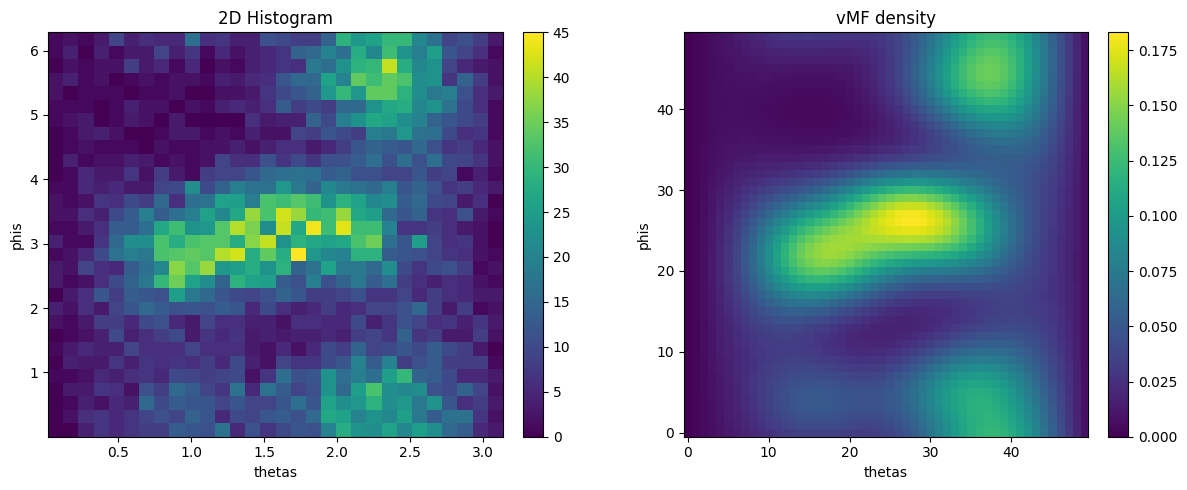

In [4]:
rs, ths, phs = cart2sph(samples[:,0], samples[:,1], samples[:,2])
# Create a single figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Wider figure to fit both plots

# First subplot: 2D Histogram
im1 = axes[0].hist2d(ths, phs, bins=30, cmap="viridis")
fig.colorbar(im1[3], ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbar
axes[0].set_title("2D Histogram")
axes[0].set_xlabel("thetas")
axes[0].set_ylabel("phis")

# Second subplot: vMF Density
im2 = axes[1].imshow(f_vmf.T, cmap='viridis', interpolation='nearest', origin='lower')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  # Add colorbar
axes[1].set_title("vMF density")
axes[1].set_xlabel("thetas")
axes[1].set_ylabel("phis")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

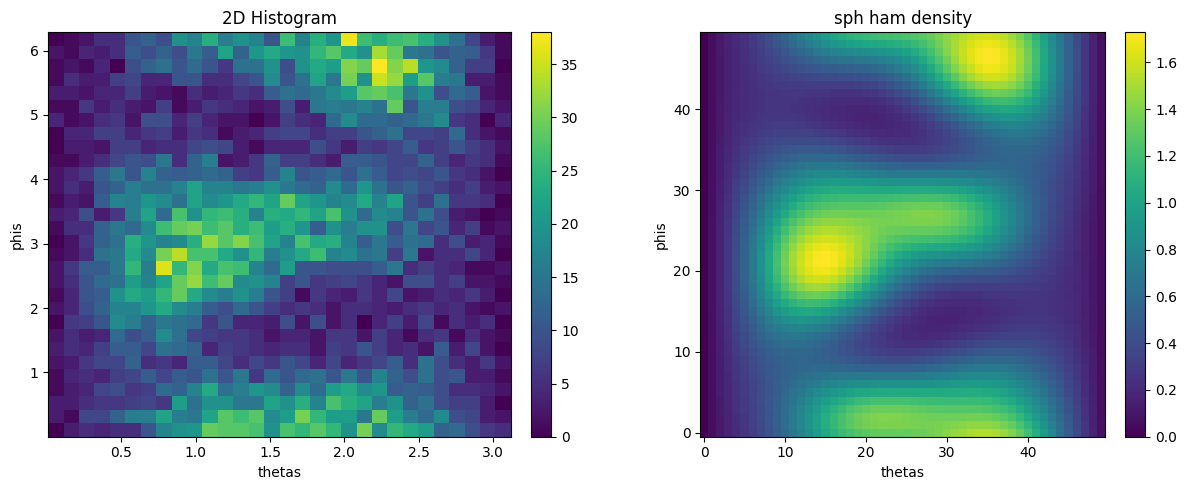

In [5]:
# expand the symmetrized density and draw samples 
def my_fun(th,ph):
    grid = Grid_3d(type='spherical', ths=np.array([th]),phs=np.array([ph]))
    return 4*np.pi*vMF_density(centers,w_vmf,kappa,grid)[0]

ell_max_half_view = 4
sph_coef, indices = sph_harm_transform(my_fun, ell_max_half_view)

f_vmf_expand = sph_harm_eval(sph_coef, ell_max_half_view, grid)
f_vmf_expand = f_vmf_expand*np.sin(grid.ths)
f_vmf_expand = np.real(f_vmf_expand.reshape([ngrid, ngrid]))


# plt.imshow(f_vmf_expand.T, cmap='viridis', interpolation='nearest', origin='lower')
# plt.colorbar(label='Value')  # Add a colorbar for reference
# plt.title("vMF density")
# plt.xlabel("thetas")
# plt.ylabel("phis")
# plt.show()


samples = sample_sph_coef(N, sph_coef, ell_max_half_view, C=5.0)
rs, ths, phs = cart2sph(samples[:,0], samples[:,1], samples[:,2])


fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Wider figure to fit both plots

# First subplot: 2D Histogram
im1 = axes[0].hist2d(ths, phs, bins=30, cmap="viridis")
fig.colorbar(im1[3], ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbar
axes[0].set_title("2D Histogram")
axes[0].set_xlabel("thetas")
axes[0].set_ylabel("phis")

# Second subplot: vMF Density
im2 = axes[1].imshow(f_vmf_expand.T, cmap='viridis', interpolation='nearest', origin='lower')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  # Add colorbar
axes[1].set_title("sph ham density")
axes[1].set_xlabel("thetas")
axes[1].set_ylabel("phis")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [6]:
# get the spherical FB coefficient of the volume
with mrcfile.open('../data/emd_34948.map') as mrc:
    data = mrc.data

Vol = Volume(data)
ds_res = 64 
Vol = Vol.downsample(ds_res)
vol = Vol.asnumpy()
vol = vol[0]


ell_max_vol = 5
# spherical bessel transform 
vol_coef, k_max, r0, indices_vol = sphFB_transform(vol, ell_max_vol)

In [7]:
# form moments using quadrature method 
r2_max = 30 
r3_max = 30 
tol2 = 0.01 
tol3 = 0.01 
grid = get_2d_unif_grid(ds_res,1/ds_res)
grid = Grid_3d(xs=grid.xs, ys=grid.ys, zs=np.zeros(grid.ys.shape))

opts = {}
opts['r2_max'] = r2_max
opts['r3_max'] = r3_max
opts['tol2'] = tol2 
opts['tol3'] = tol3 
opts['grid'] = grid

rot_coef = sph_t_rot_coef(sph_coef, ell_max_half_view)
subMoMs = coef_t_subspace_moments(vol_coef, ell_max_vol, k_max, r0, indices_vol, rot_coef, ell_max_half_view, opts)

getting the first moment
getting the second moment
getting the third moment


In [8]:
# form sketched moments using Monte Carlo
M1 = subMoMs['M1']
M2 = subMoMs['M2']
M3 = subMoMs['M3']
G = subMoMs['G']
G1 = subMoMs['G1']
G2 = subMoMs['G2']
m1 = subMoMs['m1']
m2 = subMoMs['m2']
m3 = subMoMs['m3']
U2 = subMoMs['U2']
U3 = subMoMs['U3']
_, betas, alphas = cart2sph(samples[:,0],samples[:,1],samples[:,2]) 
gammas = np.random.uniform(0,2*np.pi,(N,))

M1_emp = 0 
M2_emp = 0
M3_emp = 0
for i in range(N):
    Rot = Rz(alphas[i]) @ Ry(betas[i]) @ Rz(gammas[i])
    grid_proj = grid.get_rotated_grid(Rot)
    fft_img = sphFB_eval(vol_coef, ell_max_vol, k_max, r0, indices_vol, grid_proj)
    fft_img = fft_img.reshape(-1,1)
    M1_emp += fft_img/N 
    M2_emp += fft_img @ (np.conj(fft_img).T @ G)/N
    M3_emp += fft_img @ ((np.conj(fft_img).T @ G1) * (np.conj(fft_img).T @ G2))/N


# compare the moments obtained by quadrature and Monte Carlo
print(LA.norm(M1_emp-M1)/LA.norm(M1), LA.norm(M2_emp-M2, 'fro')/LA.norm(M2, 'fro'), LA.norm(M3_emp-M3, 'fro')/LA.norm(M3, 'fro'))


0.005828687051107938 0.008352686922826792 0.008773368078856566


In [9]:
# form subspace moments using Monte Carlo
m1_emp = 0 
m2_emp = 0
m3_emp = 0
for i in range(N):
    Rot = Rz(alphas[i]) @ Ry(betas[i]) @ Rz(gammas[i])
    grid_proj = grid.get_rotated_grid(Rot)
    fft_img = sphFB_eval(vol_coef, ell_max_vol, k_max, r0, indices_vol, grid_proj)
    fft_img = fft_img.reshape(-1,1)
    I1 = np.conj(U2).T @ fft_img
    I2 = np.conj(U2).T @ fft_img
    I3 = np.conj(U3).T @ fft_img.flatten()
    m1_emp += I1/N
    m2_emp += I2 @ np.conj(I2).T / N
    m3_emp += np.einsum('i,j,k->ijk', I3, I3, I3)/N


    

print(LA.norm(m1_emp-m1)/LA.norm(m1))
print(LA.norm(m2_emp-m2, 'fro')/LA.norm(m2, 'fro'))
print(LA.norm(m3_emp.flatten()-m3.flatten())/LA.norm(m3.flatten()))


0.005612495635330161
0.008559215831476178
0.011008582703700299


In [10]:
def precomp_Phi(U, ell_max, k_max, r0, indices, euler_nodes, grid):
    
    c = 0.5 
    ndim = U.shape[1]
    n_so3 = euler_nodes.shape[0]
    n_basis = len(indices)
    n_grid = len(grid.rs)
    r_idx =  (grid.rs>c)
    Phi_precomp = np.zeros((n_so3, ndim, n_basis), dtype=np.complex128)

    lpall = norm_assoc_legendre_all(ell_max, np.cos(grid.ths))
    lpall /= np.sqrt(4*np.pi)

    exp_all = np.zeros((2*ell_max+1,n_grid), dtype=complex)
    for m in range(-ell_max,ell_max+1):
        exp_all[m+ell_max,:] = np.exp(1j*m*grid.phs)

    sphFB_r_t_c, _ = get_sphFB_r_t_c_mat(ell_max, k_max, indices)

    jlk = {} 
    for ell in range(0,ell_max+1):
        for k in range(0,k_max[ell]):
            z0k = r0[ell][k]
            js = spherical_jn(ell, grid.rs*z0k/c)
            djs = spherical_jn(ell, z0k, True)
            js = js*np.sqrt(2/c**3)/abs(djs)
            js[r_idx] = 0
            jlk[(ell,k)] = js 

    Yl = {} 
    for ell in range(0,ell_max+1):
        yl = np.zeros((n_grid, 2*ell+1), dtype=np.complex128)
        for m in range(-ell,ell+1):
            lpmn = lpall[ell,abs(m),:]
            if m<0:
                lpmn = (-1)**m * lpmn
            yl[:,m+ell] = lpmn*exp_all[m+ell_max,:]
        Yl[ell] = yl  


    for i in range(n_so3):
        alpha, beta, gamma = euler_nodes[i,:]
        for ell in range(0,ell_max+1):
            D_l = wignerD(ell, alpha, beta, gamma)
            Yl_rot = Yl[ell] @ np.conj(D_l).T 
            for k in range(0,k_max[ell]):
                Flk = np.einsum('i,ij->ij', jlk[(ell,k)], Yl_rot)
                Phi_precomp[i,:,indices[(ell,k,-ell)]:indices[(ell,k,ell)]+1] = np.conj(U).T @ Flk

        Phi_precomp[i,:,:] = Phi_precomp[i,:,:] @ sphFB_r_t_c


    return Phi_precomp

In [ ]:
# check the precomputation of Phi is correct on the first moment 

sphFB_r_t_c, sphFB_c_t_r = get_sphFB_r_t_c_mat(ell_max_vol, k_max, indices_vol)
a = np.real(sphFB_c_t_r @ vol_coef)

euler_nodes, weights = load_so3_quadrature(ell_max_vol, 2*ell_max_half_view)
Phi_precomp = precomp_sphFB_all(U2, ell_max_vol, k_max, r0, indices_vol, euler_nodes, grid)

Img_all = np.einsum('ijk,k->ij',Phi_precomp,a) 
_Img_all = np.zeros(Img_all.shape, dtype=np.complex128)

for i in range(euler_nodes.shape[0]):
    alpha, beta, gamma = euler_nodes[i,:]
    Rot = Rz(alpha) @ Ry(beta) @ Rz(gamma)
    grid_proj = grid.get_rotated_grid(Rot)
    _Img_all[i,:] = np.conj(U2).T @ sphFB_eval(vol_coef, ell_max_vol, k_max, r0, indices_vol, grid_proj)

LA.norm(Img_all.flatten()-_Img_all.flatten())/LA.norm(_Img_all.flatten())




2.0846599235783975e-08

In [ ]:
# check the precomputation of Psi is correct on the first moment

sph_r_t_c , sph_c_t_r =  get_sph_r_t_c_mat(ell_max_half_view)
b = sph_c_t_r @ rot_coef 
Psi_precomp = precomp_wignerD_all(ell_max_half_view, euler_nodes)
rot_density_all = np.real(Psi_precomp @ b) 

m1_test = np.zeros(m1.shape, dtype=np.complex128)
for i in range(euler_nodes.shape[0]):
    m1_test = m1_test + weights[i]*rot_density_all[i]*Img_all[i,:].reshape((-1,1))

LA.norm(m1_test-m1,'fro')/LA.norm(m1,'fro')